In [1]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-oq1j8i0z
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-oq1j8i0z
  Resolved https://github.com/qubvel/segmentation_models.pytorch to commit 22d84a7180f299da877490cf79104f57b343f1af
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00:00:01m00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 

In [2]:
!pip install lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.1/821.1 kB 35.2 MB/s eta 0:00:00


In [3]:
import os
import h5py
import torch
import cv2
import numpy as np
import pandas as pd
import lightning as L
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from torch.optim import lr_scheduler
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

In [4]:
print(torch.cuda.is_available())
print(torch.version.cuda)

True
12.4


# Loading data
The dataset used for this training is from [Landslide4Sense](https://github.com/iarai/Landslide4Sense-2022) competition. It is a set of:
 - train images + segmentation masks
 - validation images + segmentation masks
 - test images + segmentation masks

In [5]:
DATA_DIR = "/kaggle/input/landslide4sense-modified/Land4Sense_Modified"

x_train_dir = os.path.join(DATA_DIR, "train", "images")
y_train_dir = os.path.join(DATA_DIR, "train", "masks")

x_valid_dir = os.path.join(DATA_DIR, "validation", "images")
y_valid_dir = os.path.join(DATA_DIR, "validation", "masks")

x_test_dir = os.path.join(DATA_DIR, "test", "images")
y_test_dir = os.path.join(DATA_DIR, "test", "masks")

## Dataloader
Writing helper class for data extraction, tranformation and preprocessing
https://pytorch.org/docs/stable/data

In [6]:
class Dataset(BaseDataset):
    """
    Dataset class for binary segmentation of landslide areas.
    Reads images and corresponding masks, applies optional augmentations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to masks folder
        augmentation (albumentations.Compose, optional): data augmentation pipeline
    """

    def __init__(self, images_dir, masks_dir, augmentation=None):
        self.ids = sorted(os.listdir(images_dir))
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]

        self.augmentation = augmentation

    def __getitem__(self, i):
        # Read image (RGB)
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Read mask (grayscale), convert to binary mask [0, 1]
        mask = cv2.imread(self.masks_fps[i], cv2.IMREAD_GRAYSCALE)
        mask = (mask == 255).astype("float32")  # Landslide=1, Background=0

        # Apply augmentations (if any)
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample["image"], sample["mask"]

        # Add channel dimension: (H, W) -> (1, H, W)
        return image.transpose(2, 0, 1), np.expand_dims(mask, axis=0)

    def __len__(self):
        return len(self.ids)

In [7]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(" ".join(name.split("_")).title())
        if name == "image":
            plt.imshow(image.transpose(1, 2, 0))
        else:
            plt.imshow(image)
    plt.show()

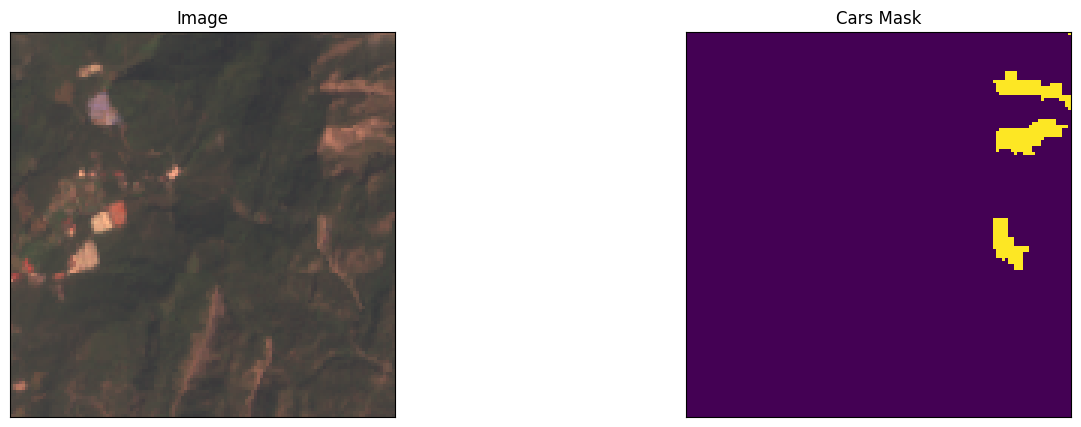

In [8]:
dataset = Dataset(x_train_dir, y_train_dir)
# get some sample
image, mask = dataset[0]
visualize(
    image=image,
    cars_mask=mask.squeeze(),
)

In [9]:
BATCH_SIZE = 32

In [10]:
train_dataset = Dataset(
    x_train_dir,
    y_train_dir,
)

valid_dataset = Dataset(
    x_valid_dir,
    y_valid_dir,
)

test_dataset = Dataset(
    x_test_dir,
    y_test_dir,
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

## Model

In [11]:
EPOCHS=10
T_MAX = EPOCHS * len(train_loader)
OUT_CLASSES = 1

In [12]:
import pytorch_lightning as pl

class LandslideMappingModel(pl.LightningModule):
    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch,
            encoder_name=encoder_name,
            in_channels=in_channels,
            classes=out_classes,
            **kwargs,
        )
        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []

        # Metric logging for CSV
        self.metric_log_path = "training_metrics.csv"
        self.logged_metrics = {
            "epoch": [],
            "stage": [],
            "loss": [],
            "per_image_iou": [],
            "dataset_iou": [],
            "f1_score": [],
            "f2_score": [],
            "accuracy": [],
            "recall": [],
            "precision": [],
        }

    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        image, mask = batch

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32,
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)

        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(
            pred_mask.long(), mask.long(), mode="binary"
        )
        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
        f2_score = smp.metrics.fbeta_score(tp, fp, fn, tn, beta=2, reduction="micro")
        accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")
        recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro-imagewise")
        precision = smp.metrics.precision(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
            f"{stage}_f1_score": f1_score,
            f"{stage}_f2_score": f2_score,
            f"{stage}_accuracy": accuracy,
            f"{stage}_recall": recall,
            f"{stage}_precision": precision,
        }

        self.log_dict(metrics, prog_bar=True)
        avg_loss = torch.stack([x["loss"] for x in outputs]).mean()

        # Store current stage metrics
        self.logged_metrics["epoch"].append(self.current_epoch)
        self.logged_metrics["stage"].append(stage)
        self.logged_metrics["per_image_iou"].append(per_image_iou.item())
        self.logged_metrics["dataset_iou"].append(dataset_iou.item())
        self.logged_metrics["f1_score"].append(f1_score.item())
        self.logged_metrics["f2_score"].append(f2_score.item())
        self.logged_metrics["accuracy"].append(accuracy.item())
        self.logged_metrics["recall"].append(recall.item())
        self.logged_metrics["precision"].append(precision.item())
        self.logged_metrics["loss"].append(avg_loss.item())

        # Save just this stage's metrics to CSV
        self.save_epoch_metrics_to_csv()

    def save_epoch_metrics_to_csv(self):
        if not self.logged_metrics["epoch"]:
            return

        df = pd.DataFrame(self.logged_metrics)
        file_exists = os.path.exists(self.metric_log_path)

        if not file_exists:
            df.to_csv(self.metric_log_path, index=False)
        else:
            df.to_csv(self.metric_log_path, mode="a", header=False, index=False)

        # Clear after saving this stage
        for key in self.logged_metrics:
            self.logged_metrics[key].clear()

    def training_step(self, batch, batch_idx):
        train_loss_info = self.shared_step(batch, "train")
        # append the metics of each step to the
        self.training_step_outputs.append(train_loss_info)
        return train_loss_info

    def on_train_epoch_end(self):
        self.shared_epoch_end(self.training_step_outputs, "train")
        # empty set output list
        self.training_step_outputs.clear()
        return

    def validation_step(self, batch, batch_idx):
        valid_loss_info = self.shared_step(batch, "valid")
        self.validation_step_outputs.append(valid_loss_info)
        return valid_loss_info

    def on_validation_epoch_end(self):
        self.shared_epoch_end(self.validation_step_outputs, "valid")
        self.validation_step_outputs.clear()
        return

    def test_step(self, batch, batch_idx):
        test_loss_info = self.shared_step(batch, "test")
        self.test_step_outputs.append(test_loss_info)
        return test_loss_info

    def on_test_epoch_end(self):
        self.shared_epoch_end(self.test_step_outputs, "test")
        # empty set output list
        self.test_step_outputs.clear()
        return

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=2e-4)
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_MAX, eta_min=1e-5)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 1,
            },
        }
        return

In [13]:
model = LandslideMappingModel("FPN", "resnext50_32x4d", in_channels=3, out_classes=OUT_CLASSES)

config.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/100M [00:00<?, ?B/s]

## Training

In [14]:
trainer = pl.Trainer(max_epochs=EPOCHS, log_every_n_steps=1)

trainer.fit(
    model,
    train_dataloaders=train_loader,
    val_dataloaders=valid_loader,
)

2025-07-04 13:41:38.999370: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751636499.197301      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751636499.256709      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

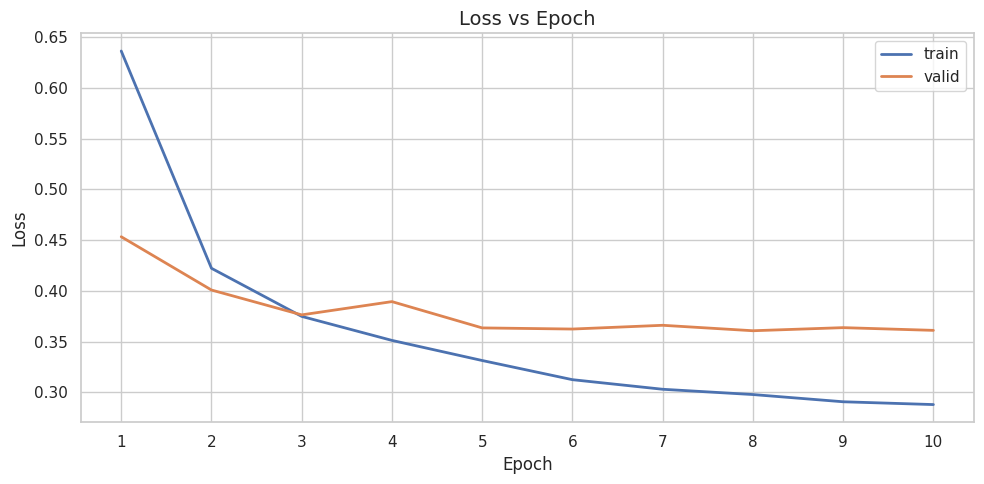

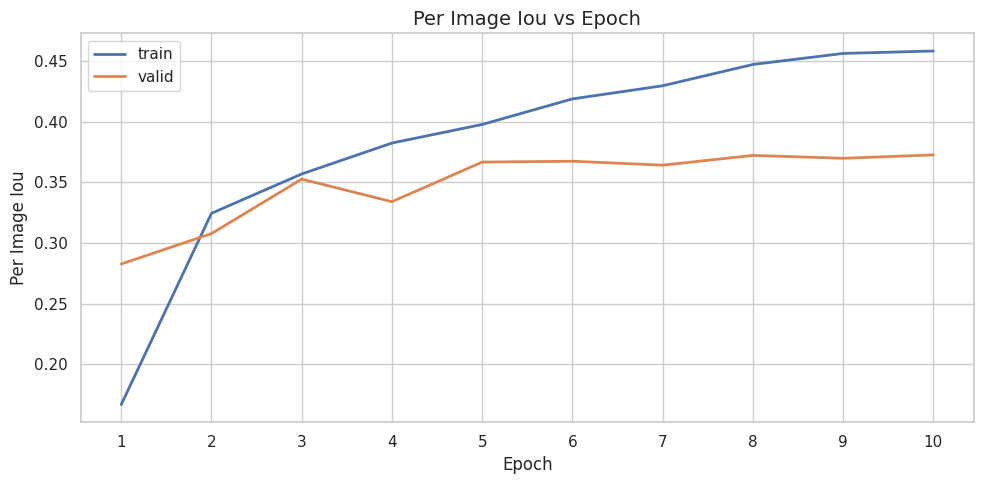

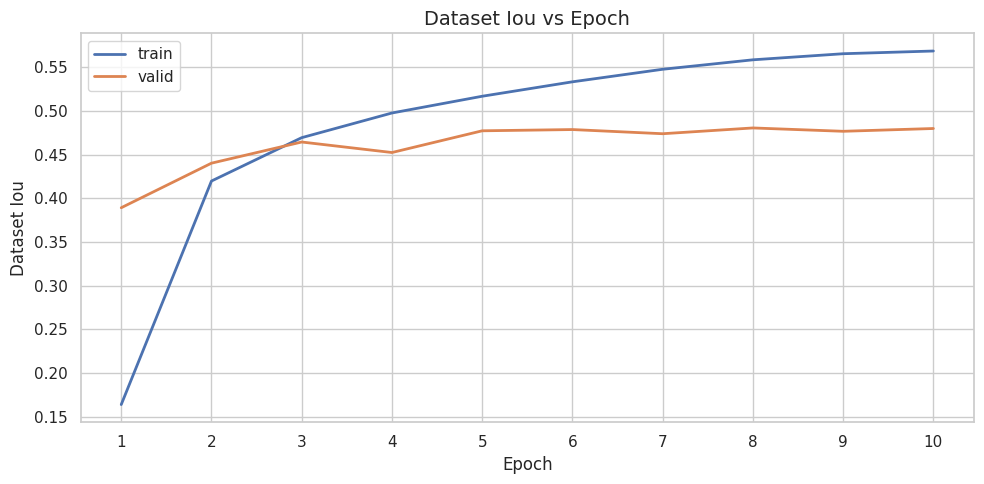

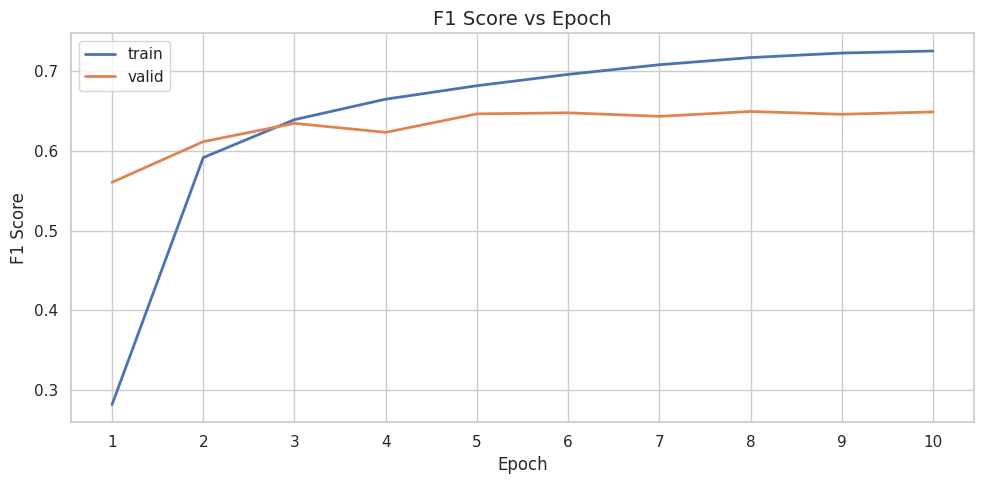

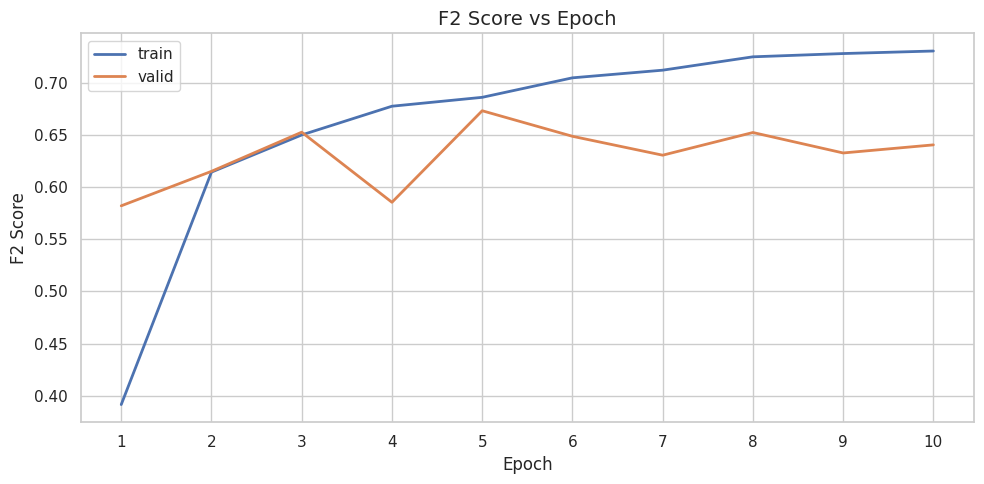

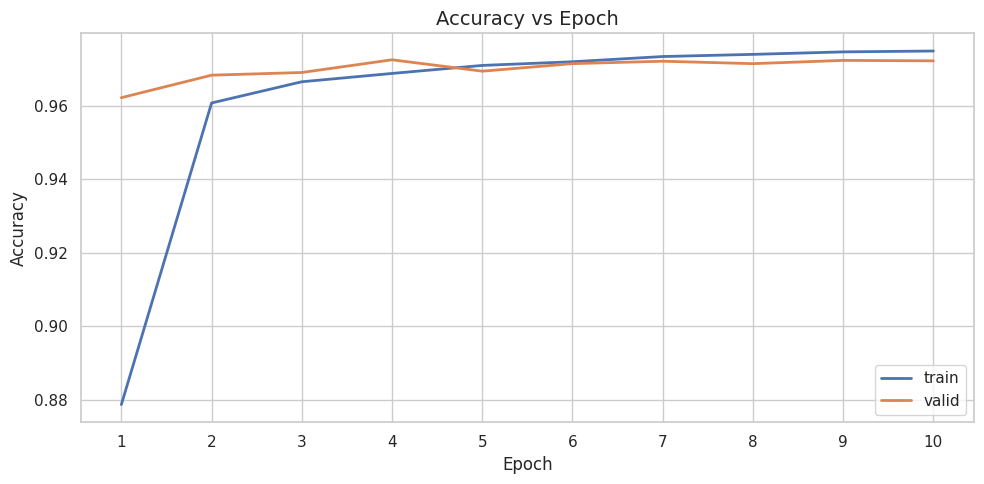

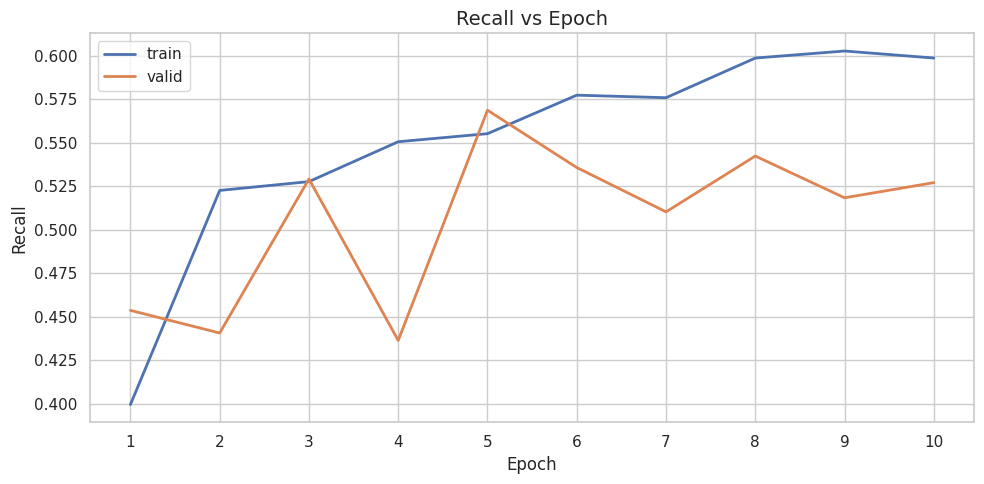

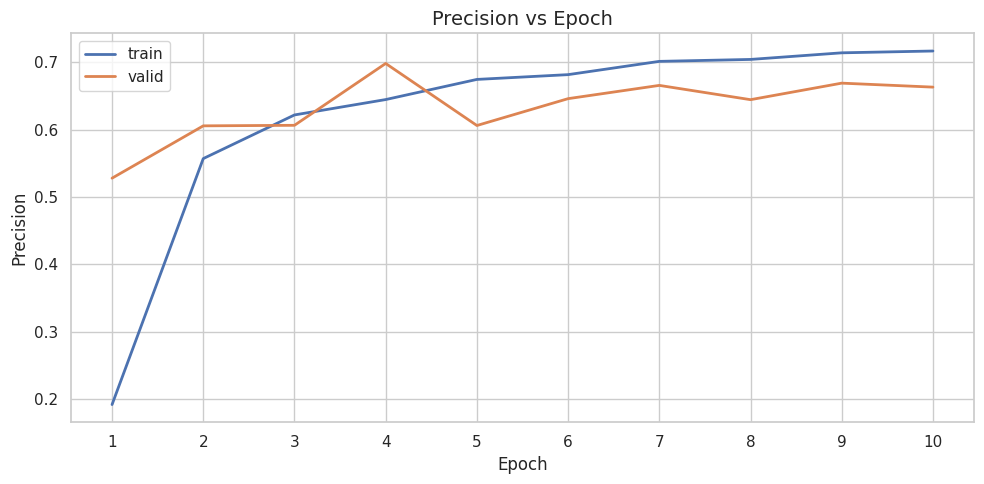

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
df = pd.read_csv("training_metrics.csv")
df = df.iloc[1:].reset_index(drop=True)

df["epoch"] = df["epoch"].astype(int) + 1

# Set seaborn style
sns.set(style="whitegrid")

# List of metric columns to plot
metrics = [
    "loss",
    "per_image_iou", "dataset_iou",
    "f1_score", "f2_score",
    "accuracy", "recall", "precision"
]

for metric in metrics:
    plt.figure(figsize=(10, 5))
    
    for stage in ["train", "valid"]:
        stage_df = df[df["stage"] == stage]
        plt.plot(stage_df["epoch"], stage_df[metric], label=stage, linewidth=2)
    
    plt.title(f"{metric.replace('_', ' ').title()} vs Epoch", fontsize=14)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel(metric.replace('_', ' ').title(), fontsize=12)
    
    # This ensures each epoch gets a properly spaced tick
    plt.xticks(sorted(df["epoch"].unique()))
    
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## Validation and test metrics

In [16]:
# run validation dataset
valid_metrics = trainer.validate(model, dataloaders=valid_loader, verbose=False)
print(valid_metrics)

Validation: |          | 0/? [00:00<?, ?it/s]

[{'valid_per_image_iou': 0.37279537320137024, 'valid_dataset_iou': 0.48001447319984436, 'valid_f1_score': 0.6486618518829346, 'valid_f2_score': 0.6403672099113464, 'valid_accuracy': 0.9722898602485657, 'valid_recall': 0.5270598530769348, 'valid_precision': 0.6629742383956909}]


In [17]:
# run test dataset
test_metrics = trainer.test(model, dataloaders=test_loader, verbose=False)
print(test_metrics)

Testing: |          | 0/? [00:00<?, ?it/s]

[{'test_per_image_iou': 0.3745250701904297, 'test_dataset_iou': 0.4665800631046295, 'test_f1_score': 0.6362830996513367, 'test_f2_score': 0.6259692907333374, 'test_accuracy': 0.9672495722770691, 'test_recall': 0.5239027142524719, 'test_precision': 0.6542494893074036}]


## Evaluation Visualization

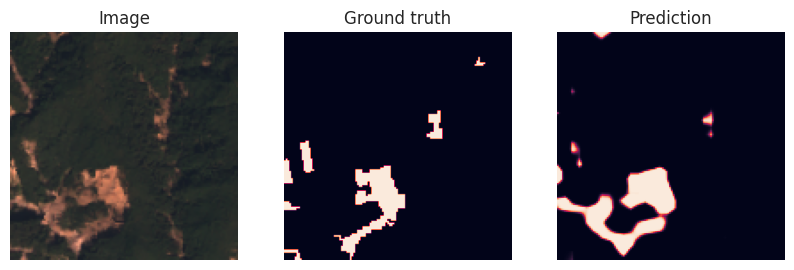

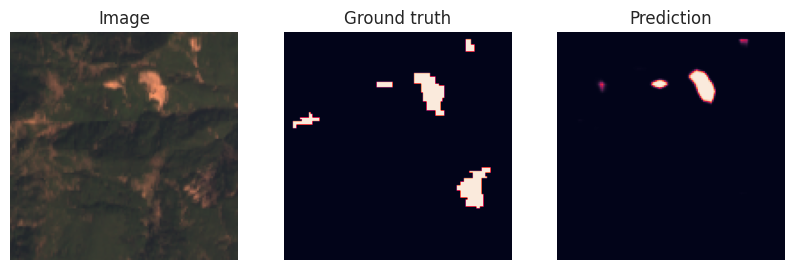

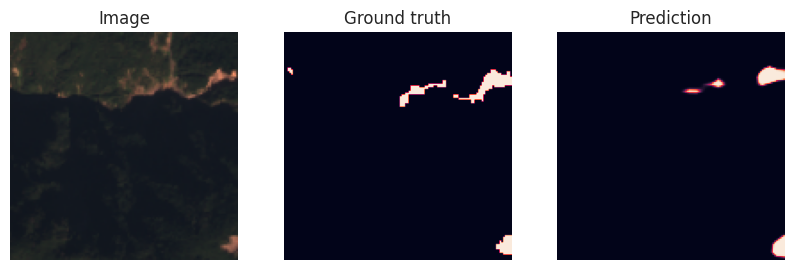

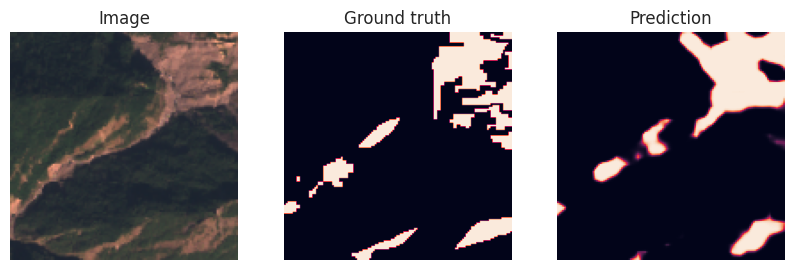

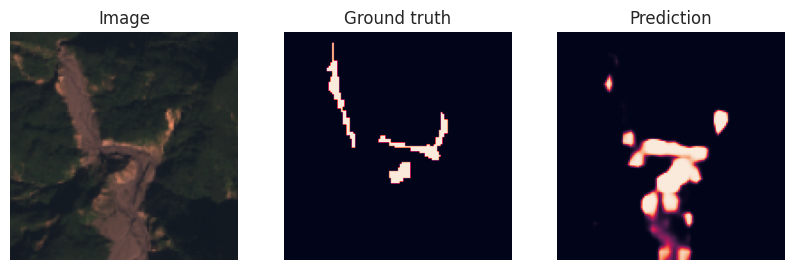

In [18]:
images, masks = next(iter(test_loader))
with torch.inference_mode():
    model.eval()
    logits = model(images)
pr_masks = logits.sigmoid()
for idx, (image, gt_mask, pr_mask) in enumerate(zip(images, masks, pr_masks)):
    # Number of samples visualized
    if idx <= 4:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(image.numpy().transpose(1, 2, 0))
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask.numpy().squeeze())
        plt.title("Ground truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pr_mask.numpy().squeeze())
        plt.title("Prediction")
        plt.axis("off")
        plt.show()
    else:
        break